In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet


import os


import numpy as np

In [2]:
import feature_engineering
import helper_functions
import problem
import datetime

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
np.random.seed(42)

In [5]:
iteration_number = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [6]:
# Define the path and filename for saving tuning results
results_path = f"./iterations/iteration_{iteration_number}"

# Ensure the results_path exists
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Load Data

In [7]:
X_train, y_train = problem.get_train_data("..")
X_test, y_test = problem.get_test_data("..")

In [8]:
# Path to results 
path_tuning = "tuning_results"

# Initalizing the Pipe

In [49]:


date_features = ["hour_cos", "hour_sin", "weekday_cos", "weekday_sin", "day_cos", "day_sin", "week_cos", "week_sin", "month_cos", "month_sin"]

numeric_features = ['latitude', 'longitude', 'temp', 'humidity', 'precip', 'windspeed', 'cloudcover', 'velib_mean', 'velib_std', 'velib_min', 'velib_25%']

categorical_features = ["year", "counter_name", "site_name"]

binary_features = ["precipprob", "in_Lockdown", "is_Rush_Hour", "is_Bank_Holiday", "if_School_Holiday", "is_workday"]

relevant_cols = date_features + numeric_features + categorical_features + binary_features

# Function to transform and add additional features
feature_transformer = FunctionTransformer(feature_engineering._additional_features,
                                          kw_args={'cols' : relevant_cols})

# Preprocessing pipeline
data_preprocessor = ColumnTransformer([
    ("numeric_scaler", StandardScaler(), numeric_features),
    ("categorical_onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("binary_passthrough", "passthrough", binary_features),
    ("date_passthrough", "passthrough", date_features)
])

# Model Evaluation

## LightGBM

In [50]:
light_gbm_params = pd.read_csv(os.path.join(path_tuning, 'tuning_LightGBM/202311261733_results.csv'))

In [51]:
light_gbm_max_params = light_gbm_params.loc[light_gbm_params['mean_test_score'] == light_gbm_params['mean_test_score'].max()]



In [52]:
# Define hyperparameters for tuning
model = LGBMRegressor(
        n_estimators=light_gbm_max_params['param_lgbmregressor__n_estimators'].values[0],
        learning_rate=light_gbm_max_params['param_lgbmregressor__learning_rate'].values[0],
        num_leaves=light_gbm_max_params['param_lgbmregressor__num_leaves'].values[0],
        min_child_samples=light_gbm_max_params['param_lgbmregressor__min_child_samples'].values[0],
        subsample=light_gbm_max_params['param_lgbmregressor__subsample'].values[0],
        subsample_freq=light_gbm_max_params['param_lgbmregressor__subsample_freq'].values[0],
        colsample_bytree=light_gbm_max_params['param_lgbmregressor__colsample_bytree'].values[0]
)


In [53]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)


In [54]:
reg_pipe.fit(X_train, y_train)

y_pred_train = reg_pipe.predict(X_train)
y_pred_test = reg_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.35
Test set, RMSE=0.32


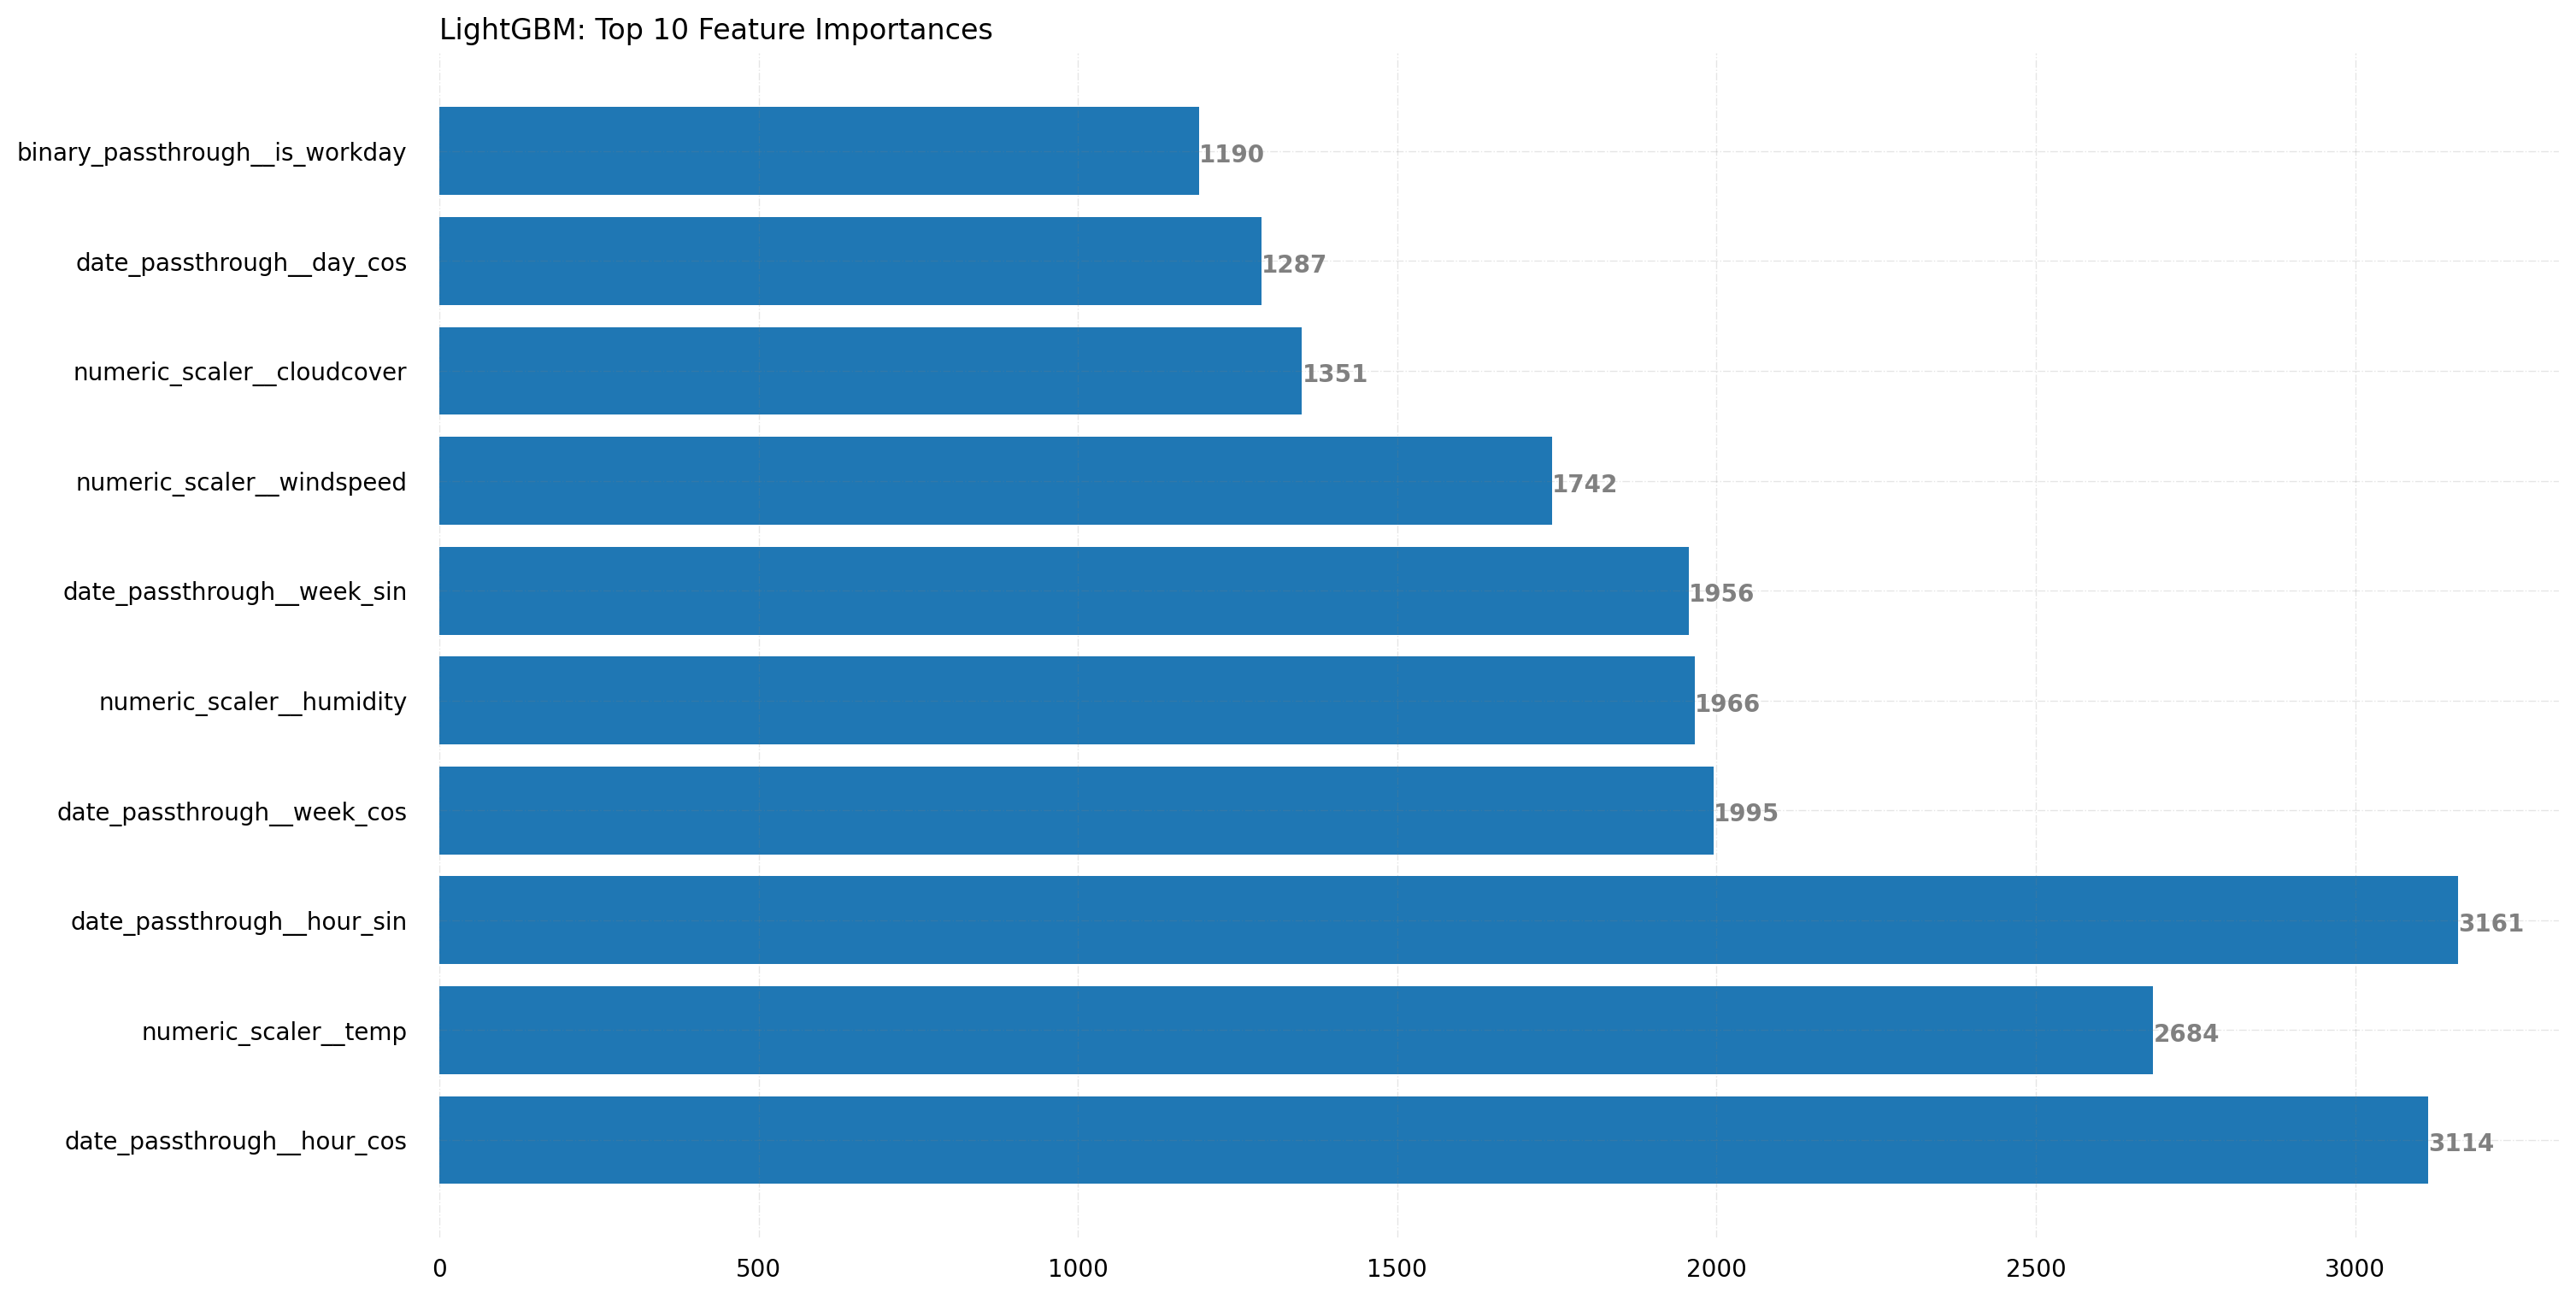

In [55]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

helper_functions.feature_importance(features, importance, 'LightGBM', results_path)

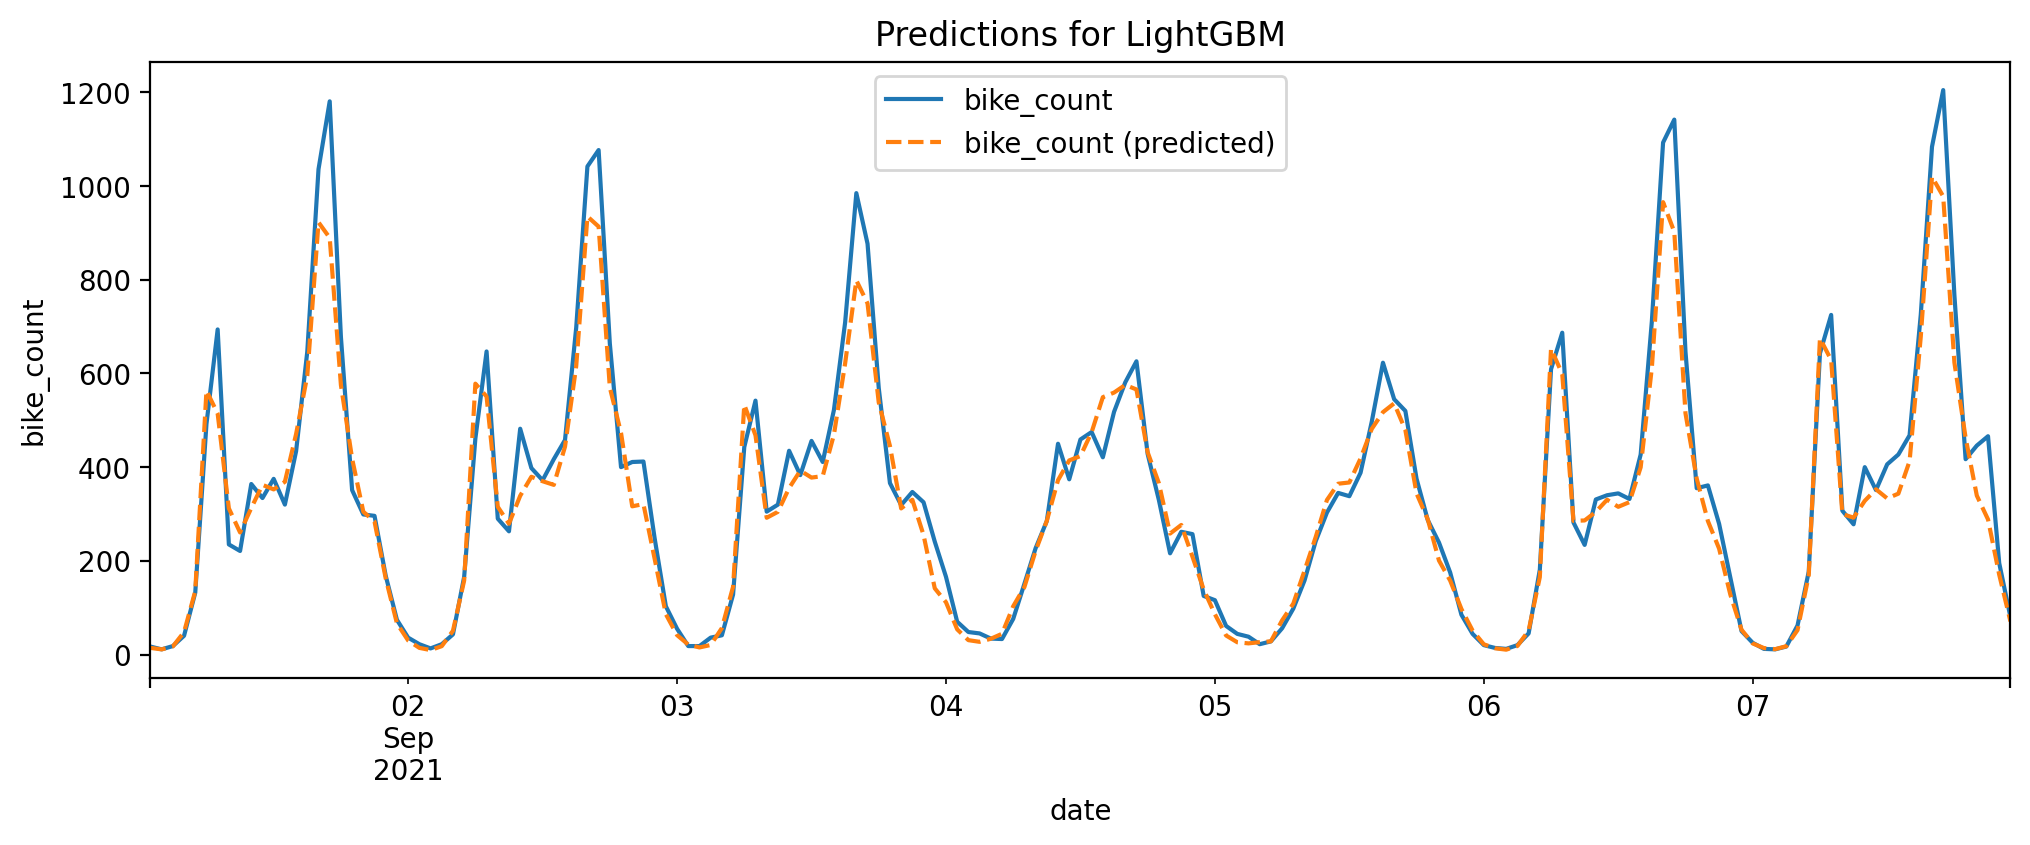

In [56]:
helper_functions.sample_week_plot(X_test, y_pred_test, y_test, 'LightGBM', results_path)

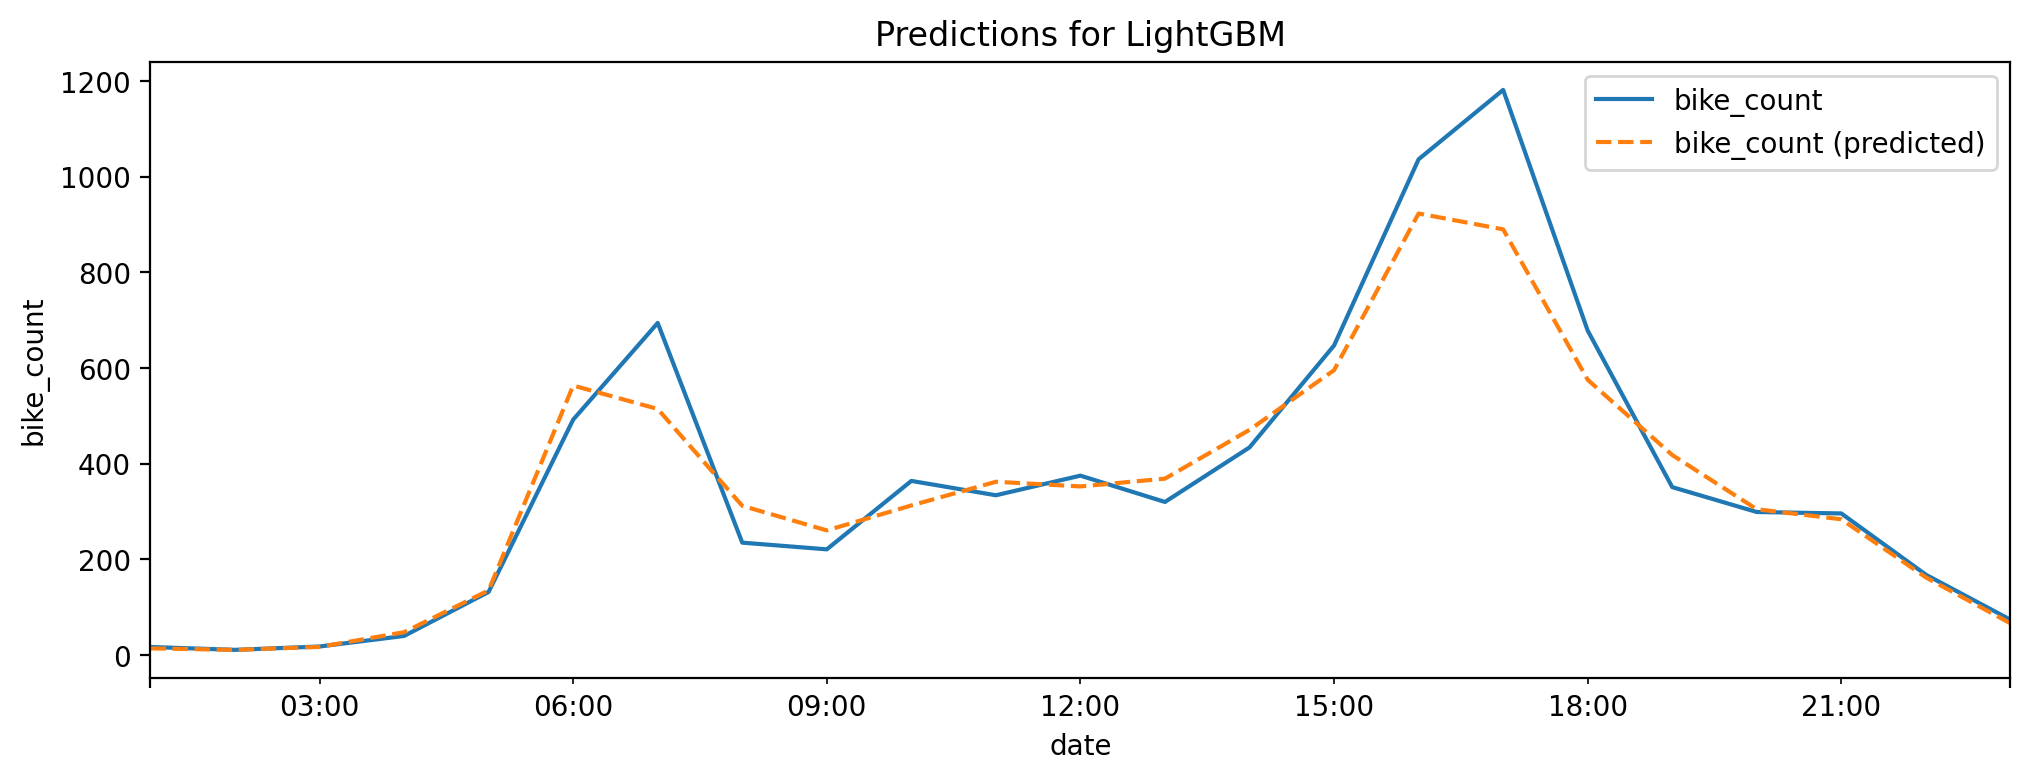

In [57]:
helper_functions.sample_day_plot(X_test, y_pred_test, y_test, 'LightGBM', results_path)

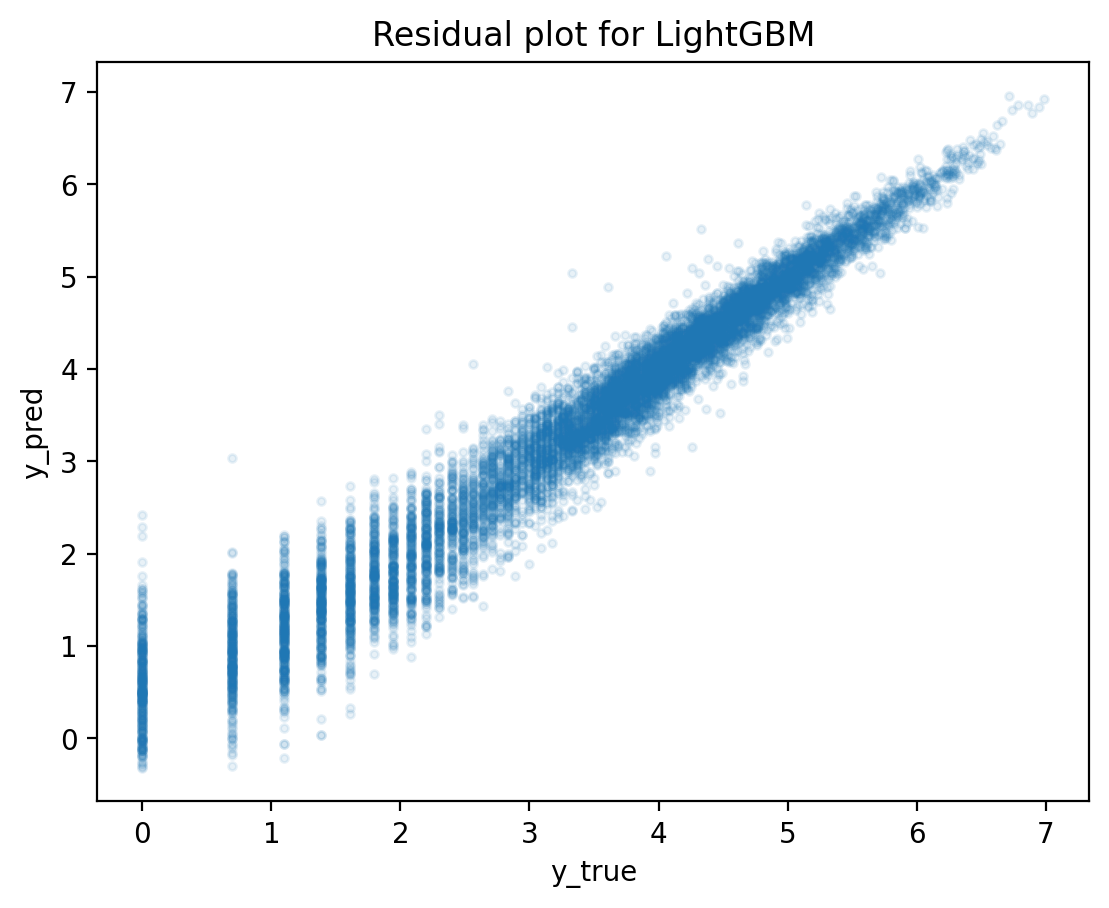

In [58]:
helper_functions.residual_plot(y_pred_test, y_test, 'LightGBM', results_path)

## XGBoost

In [99]:
xgb_params = pd.read_csv(os.path.join(path_tuning, 'tuning_XGB/202311271751_results.csv'))

In [100]:
xgb_max_params = xgb_params.loc[xgb_params['mean_test_score'] == xgb_params['mean_test_score'].max()]

In [101]:
# Define hyperparameters for tuning
model = XGBRegressor(
        n_estimators=xgb_max_params['param_xgbregressor__n_estimators'].values[0],
        learning_rate=xgb_max_params['param_xgbregressor__learning_rate'].values[0],
        colsample_bytree=xgb_max_params['param_xgbregressor__colsample_bytree'].values[0],
        colsample_bylevel=xgb_max_params['param_xgbregressor__colsample_bylevel'].values[0],
        colsample_bynode=xgb_max_params['param_xgbregressor__colsample_bynode'].values[0],
        max_depth=xgb_max_params['param_xgbregressor__max_depth'].values[0],
        subsample=xgb_max_params['param_xgbregressor__subsample'].values[0]
)

In [102]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)

In [103]:
reg_pipe.fit(X_train, y_train)

y_pred_train = reg_pipe.predict(X_train)
y_pred_test = reg_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.64
Test set, RMSE=0.55


In [104]:
xgb_params['mean_test_score'].max()

-0.7801775046786188

In [117]:
import pickle

with open(os.path.join(path_tuning, 'tuning_XGB/202311271751_best_estimator.pkl'), 'rb') as f:
    x = pickle.load(f)

In [118]:
x

{'xgbregressor__colsample_bylevel': 0.49598075964371496,
 'xgbregressor__colsample_bynode': 0.42125057343223005,
 'xgbregressor__colsample_bytree': 0.695983965452133,
 'xgbregressor__gamma': 2.361245260433491,
 'xgbregressor__learning_rate': 0.09379448199039557,
 'xgbregressor__max_depth': 6,
 'xgbregressor__n_estimators': 67,
 'xgbregressor__reg_alpha': 1.046540020714303,
 'xgbregressor__reg_lambda': 0.7768434720590788,
 'xgbregressor__subsample': 0.5813056060896185}

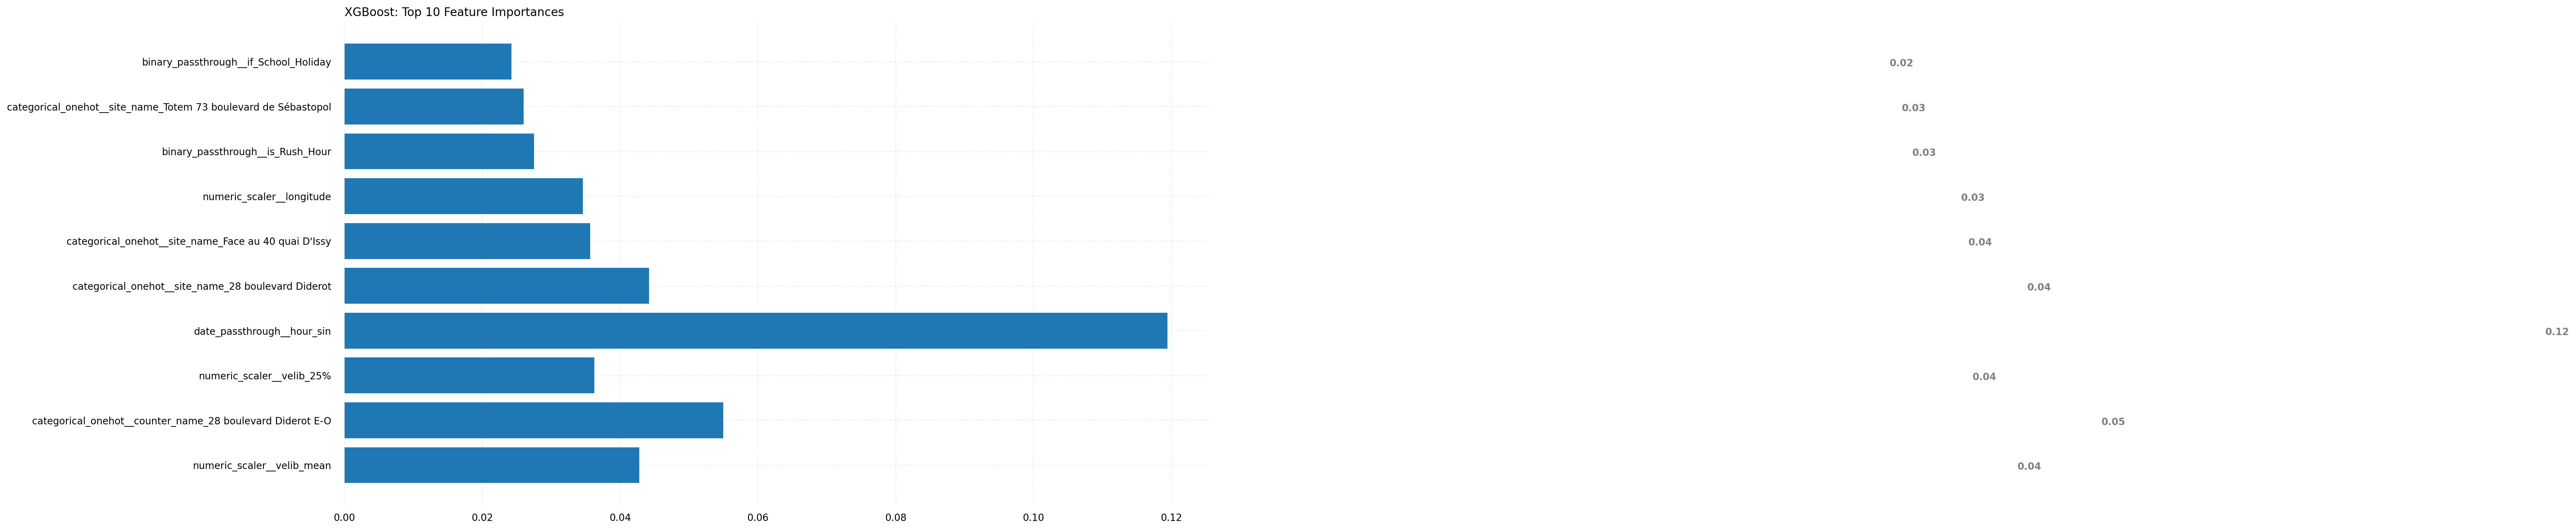

In [105]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

helper_functions.feature_importance(features, importance, 'XGBoost', results_path)

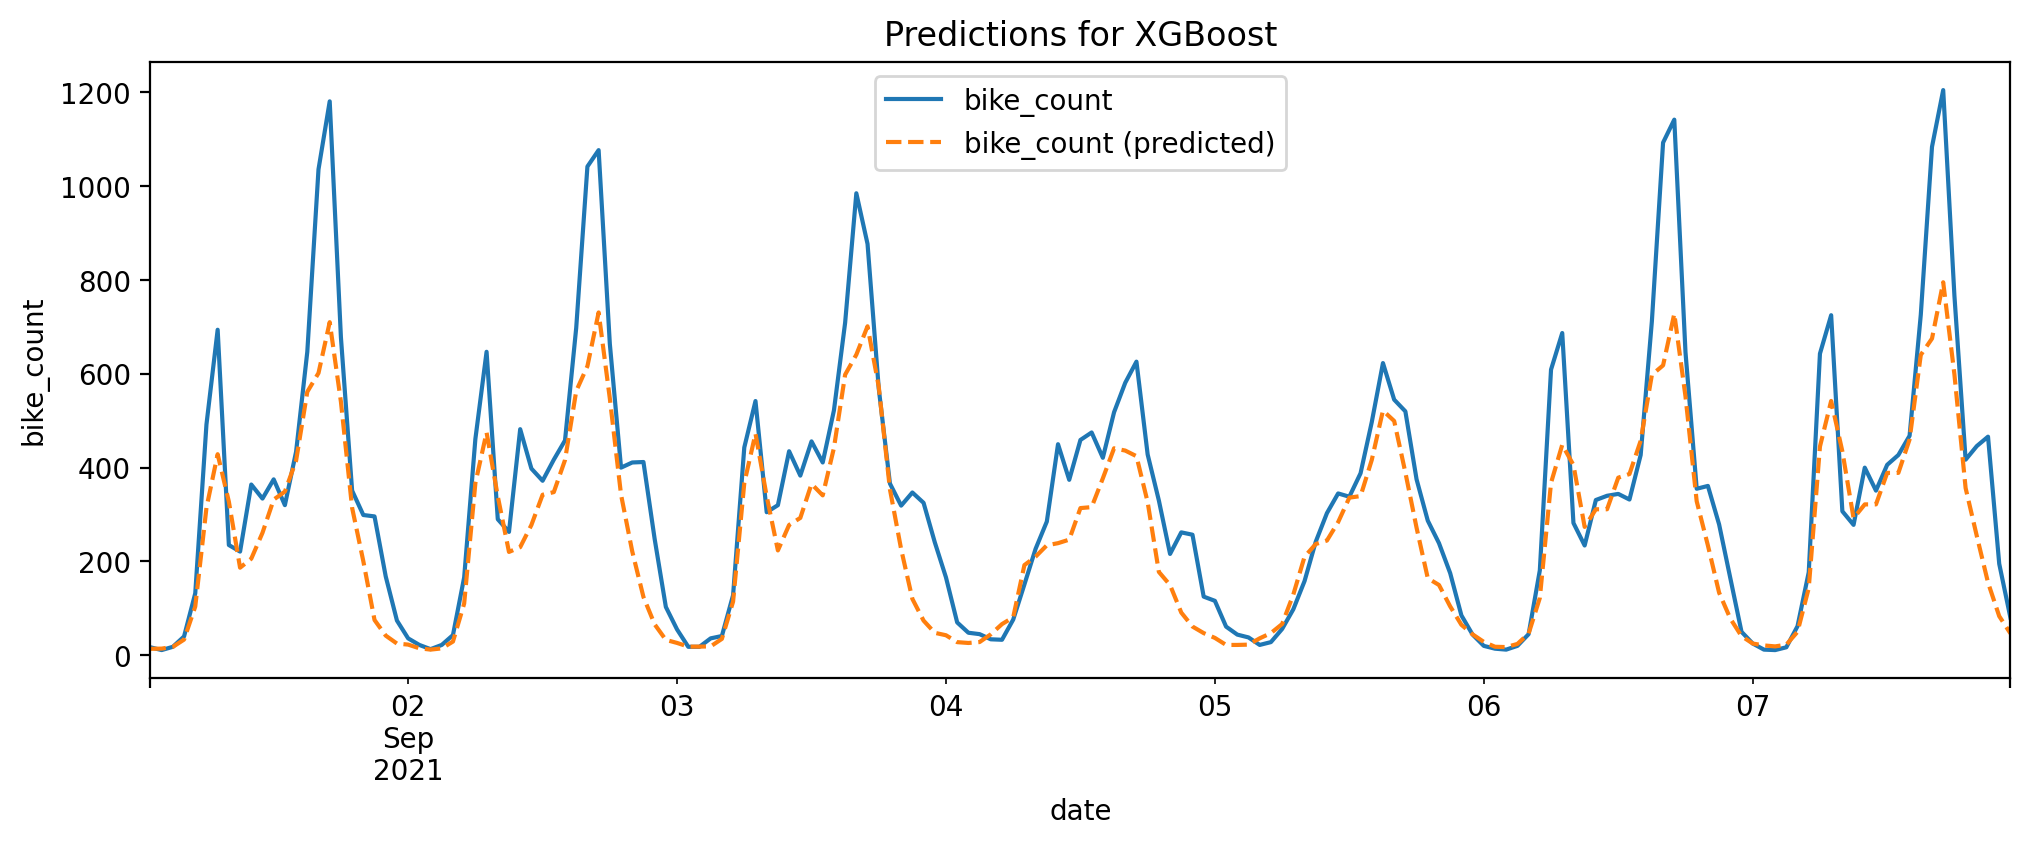

In [106]:
helper_functions.sample_week_plot(X_test, y_pred_test, y_test, 'XGBoost', results_path)

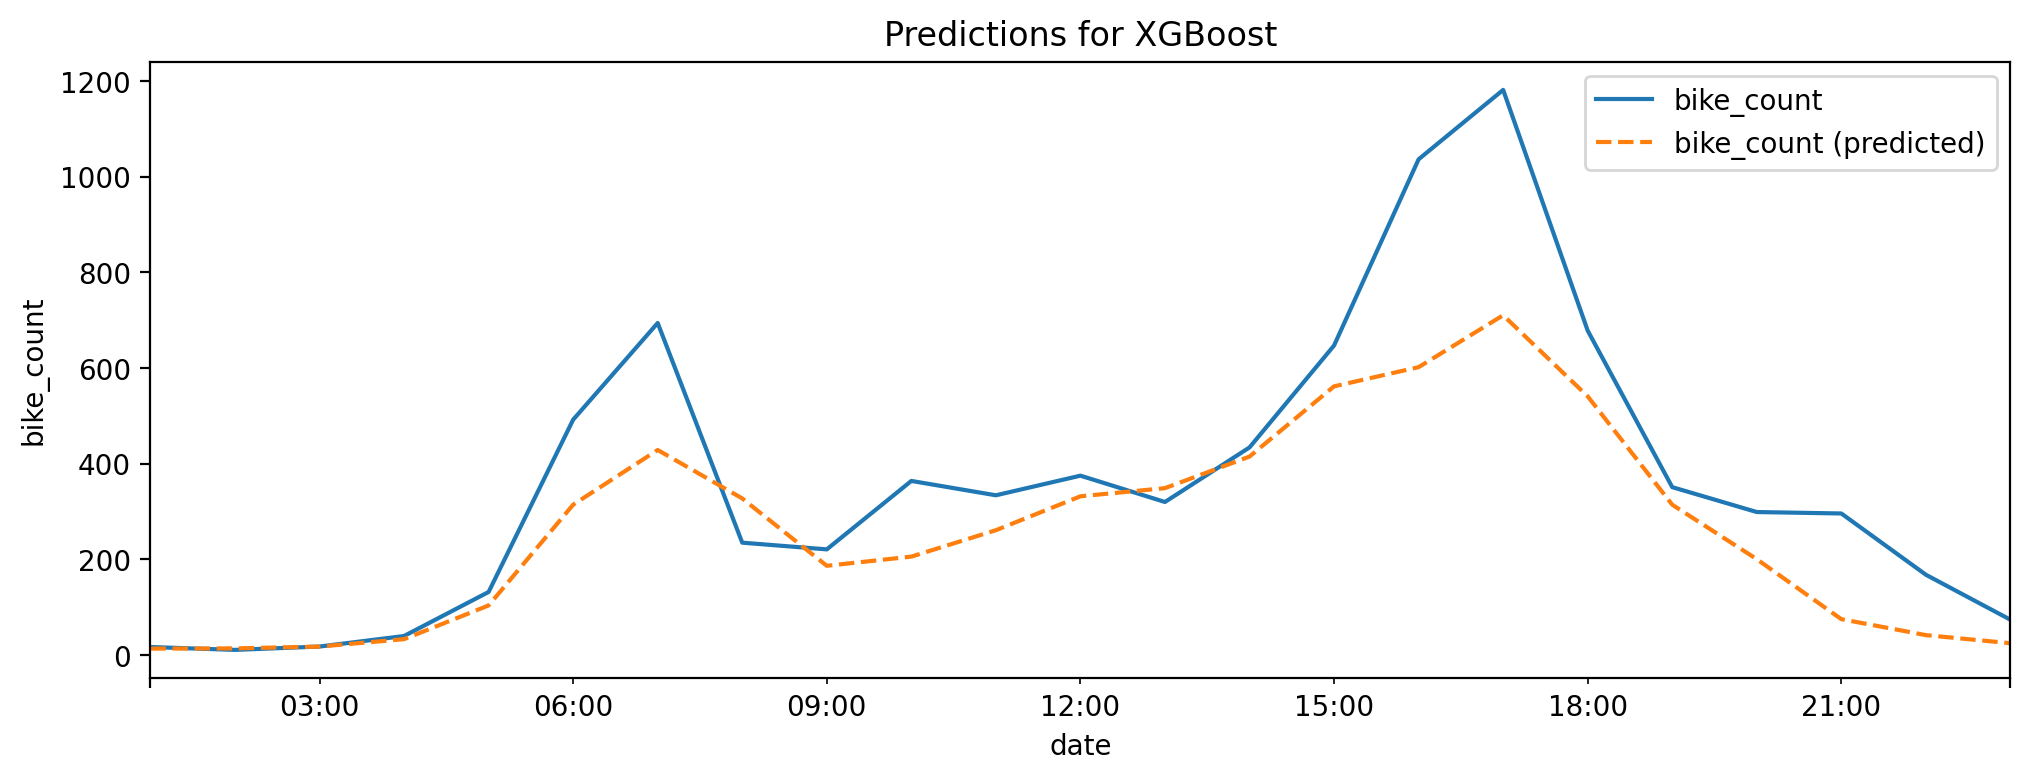

In [107]:
helper_functions.sample_day_plot(X_test, y_pred_test, y_test, 'XGBoost', results_path)

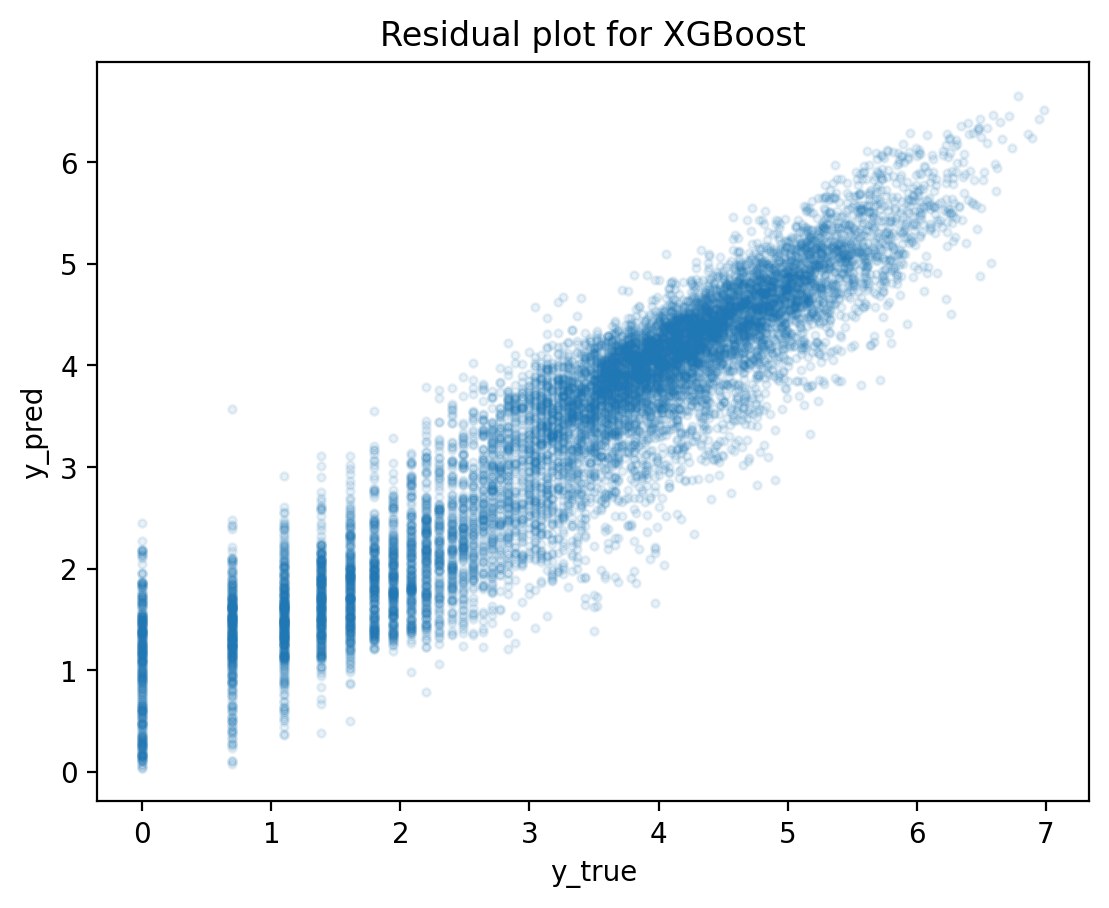

In [108]:
helper_functions.residual_plot(y_pred_test, y_test, 'XGBoost', results_path)

## ElasticNet

In [30]:
elasticnet_params = pd.read_csv(os.path.join(path_tuning, 'tuning_ElasticNet/202311261732_results.csv'))

In [31]:
elasticnet_max_params = elasticnet_params.loc[elasticnet_params['mean_test_score'] == elasticnet_params['mean_test_score'].max()]



In [32]:
# Define hyperparameters for tuning
model = ElasticNet(
        l1_ratio=elasticnet_max_params['param_elasticnet__l1_ratio'].values[0],
        alpha=elasticnet_max_params['param_elasticnet__alpha'].values[0],
)

In [33]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)

In [34]:
reg_pipe.fit(X_train, y_train)

y_pred_train = reg_pipe.predict(X_train)
y_pred_test = reg_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=1.31
Test set, RMSE=1.03


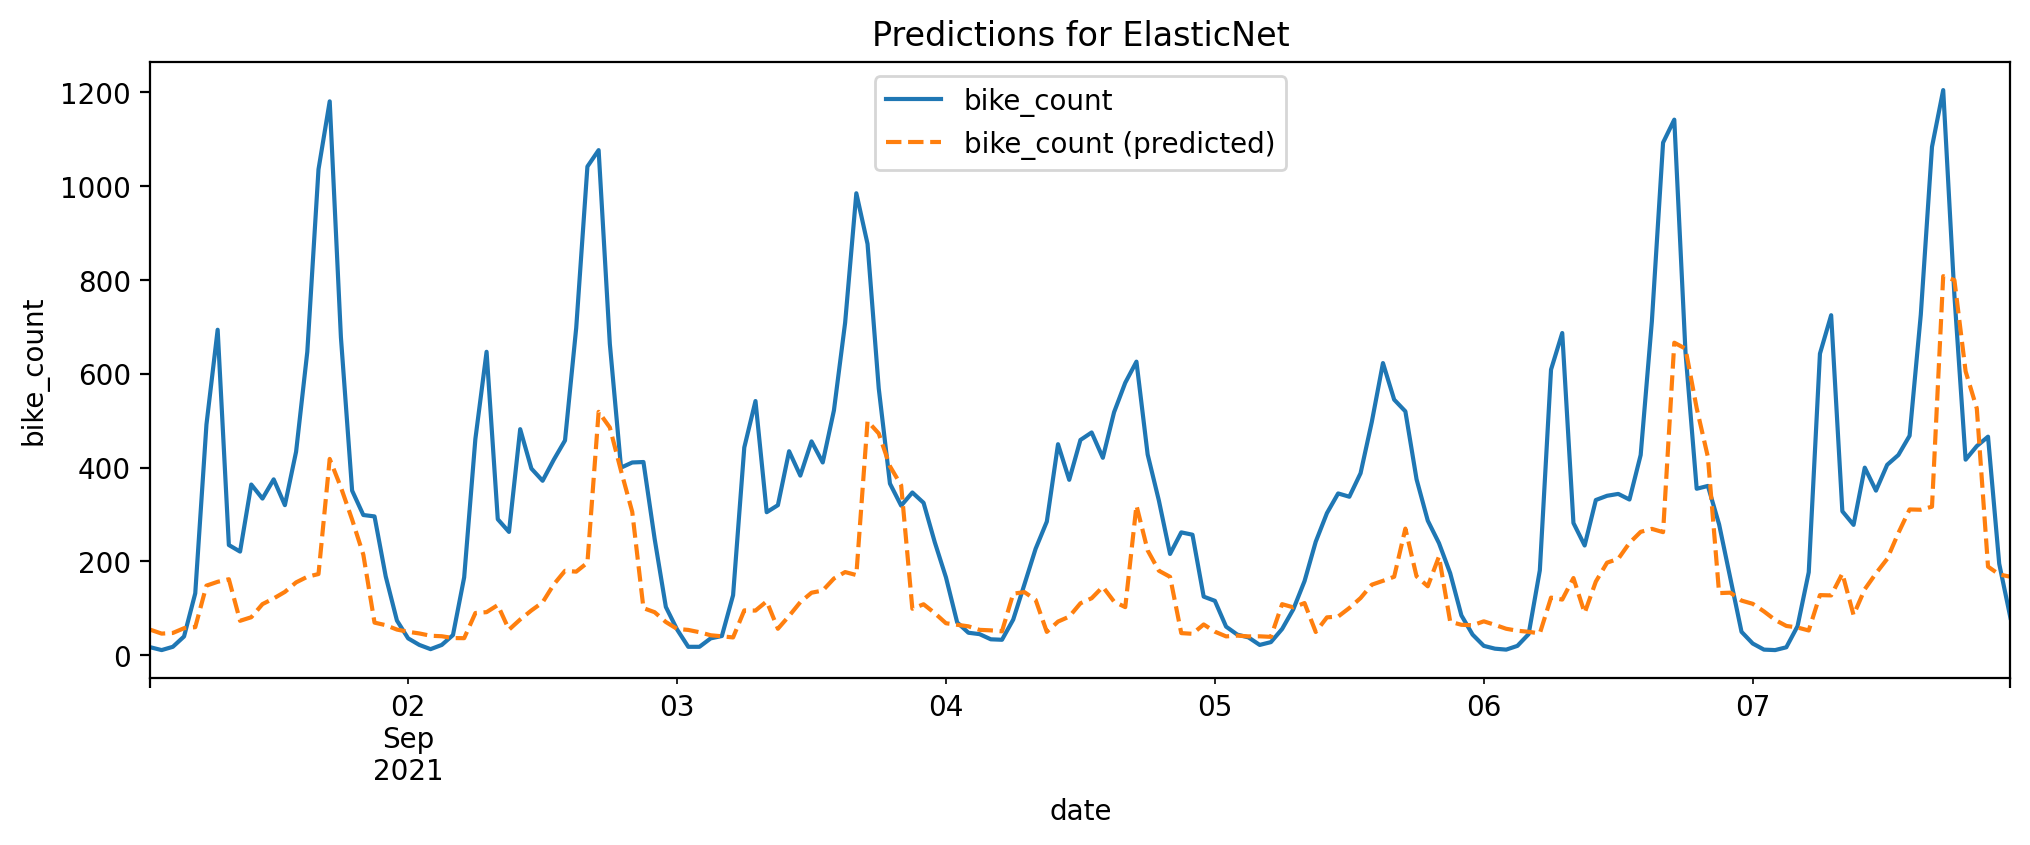

In [35]:
helper_functions.sample_week_plot(X_test, y_pred_test, y_test, 'ElasticNet', results_path)

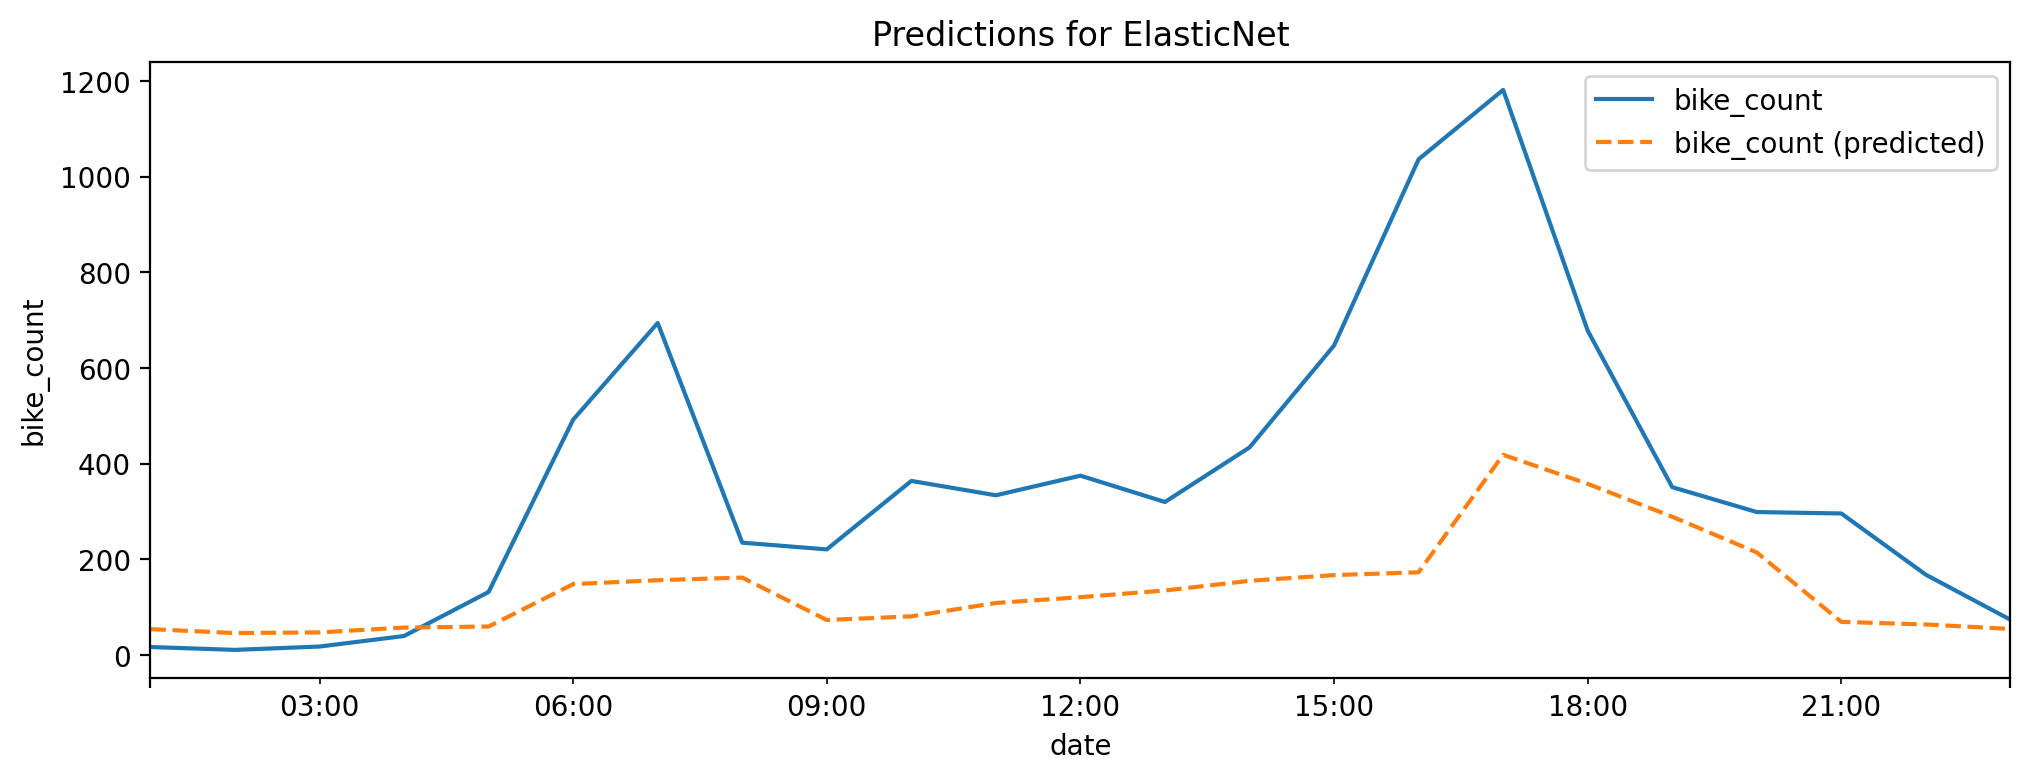

In [36]:
helper_functions.sample_day_plot(X_test, y_pred_test, y_test, 'ElasticNet', results_path)

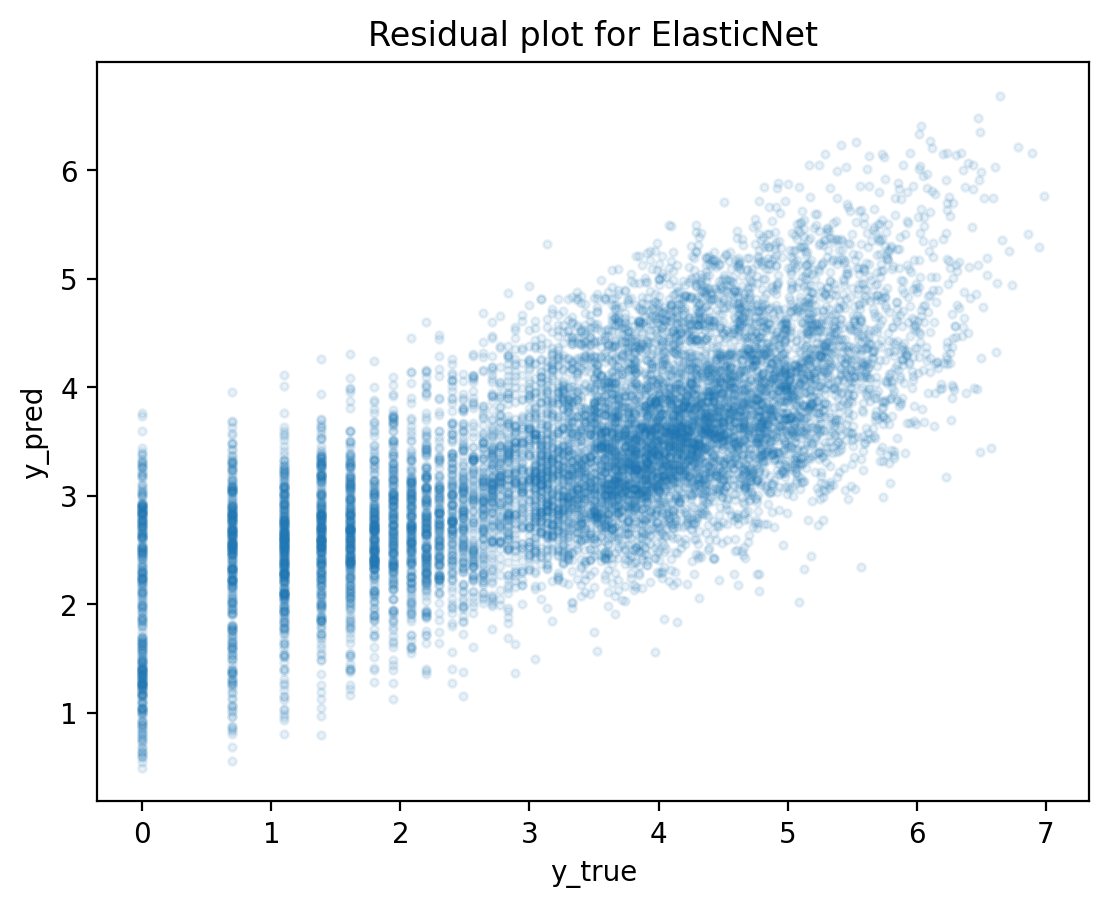

In [37]:
helper_functions.residual_plot(y_pred_test, y_test, 'ElasticNet', results_path)

# Combined Analysis

In [109]:
light_gbm_max_params = light_gbm_params.loc[light_gbm_params['mean_train_score'] == light_gbm_params['mean_train_score'].max()]
xgb_max_params = xgb_params.loc[xgb_params['mean_train_score'] == xgb_params['mean_train_score'].max()]
elasticnet_max_params = elasticnet_params.loc[elasticnet_params['mean_train_score'] == elasticnet_params['mean_train_score'].max()]

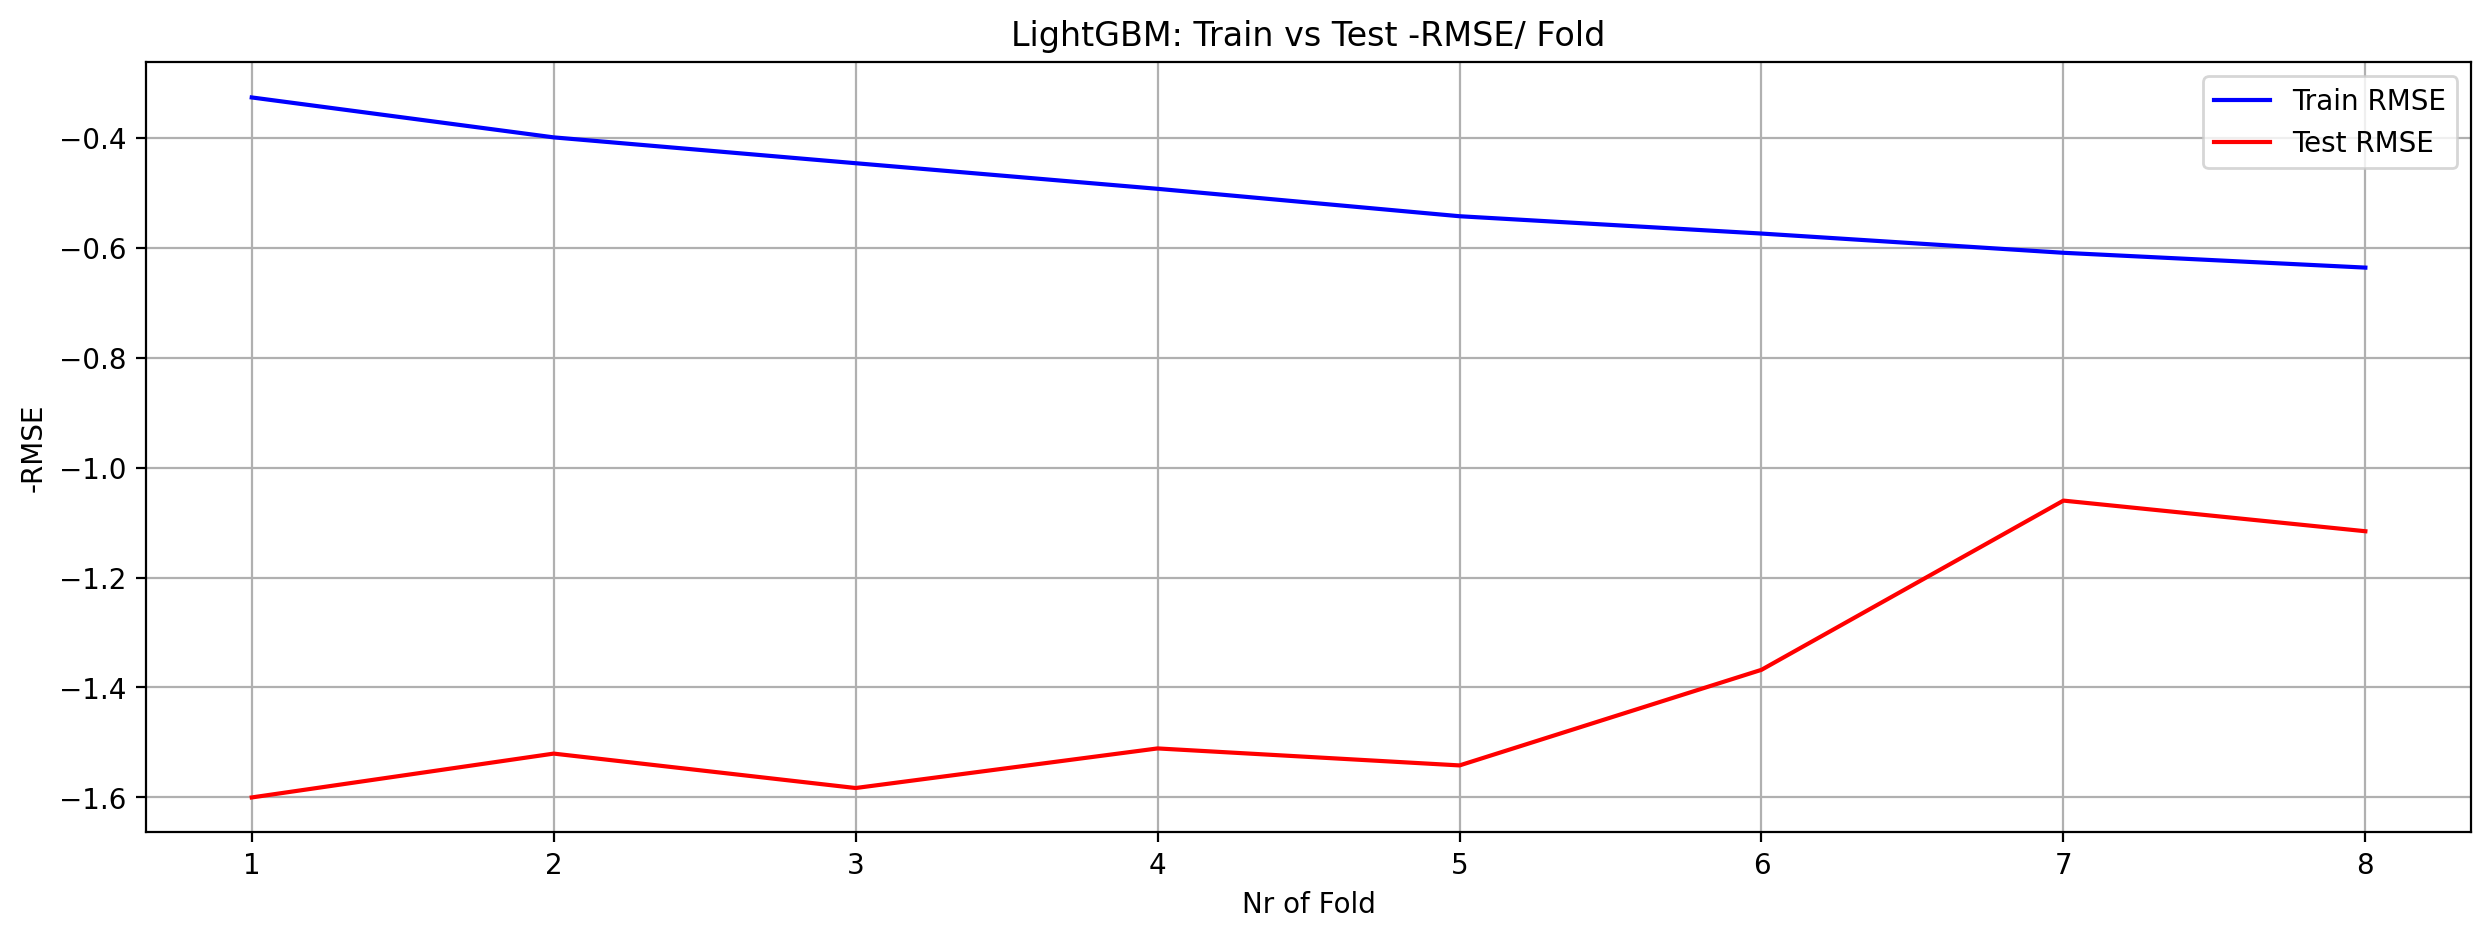

In [110]:
helper_functions.rmse_test_train_plot(light_gbm_max_params, 'LightGBM', results_path)

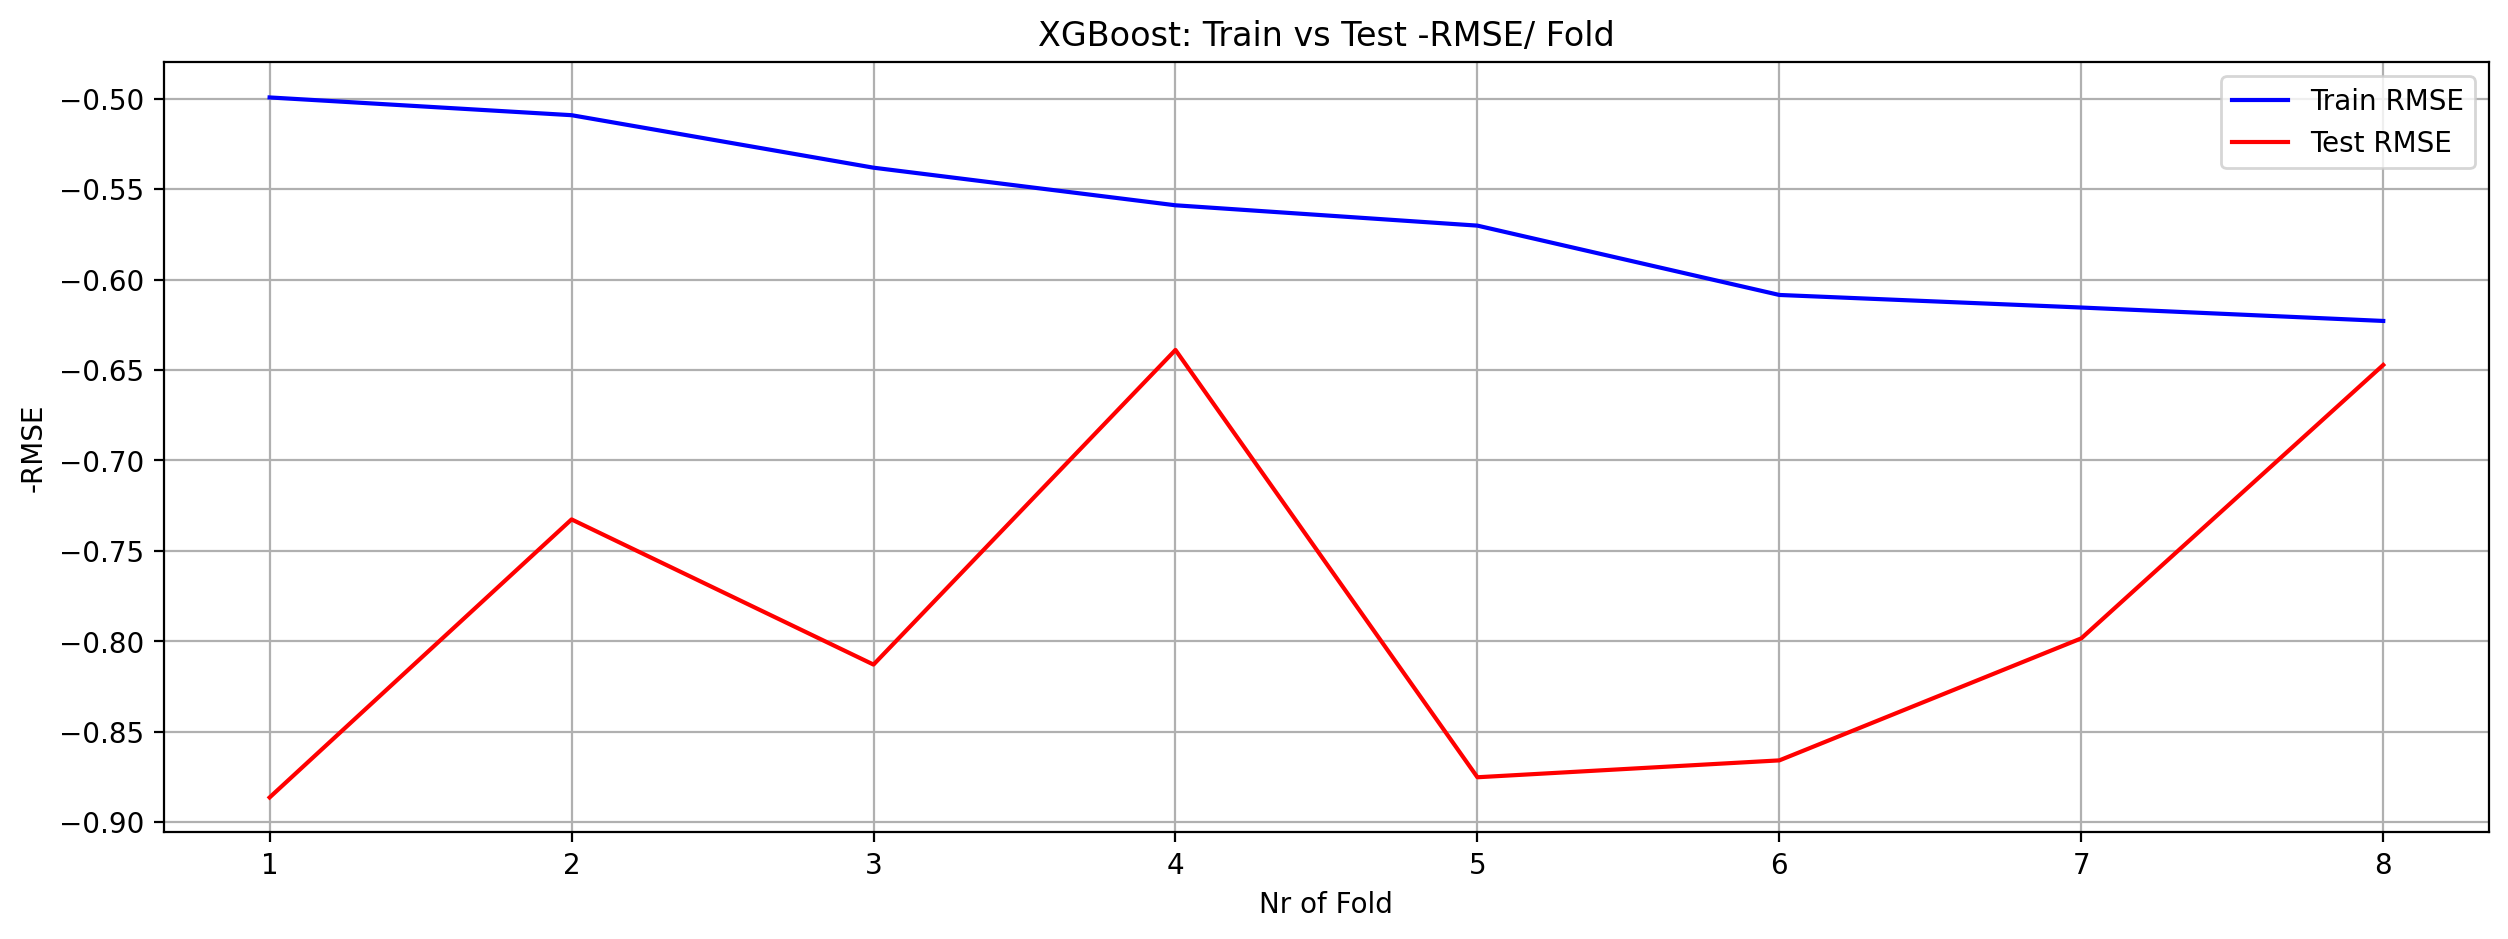

In [111]:
helper_functions.rmse_test_train_plot(xgb_max_params, 'XGBoost', results_path)

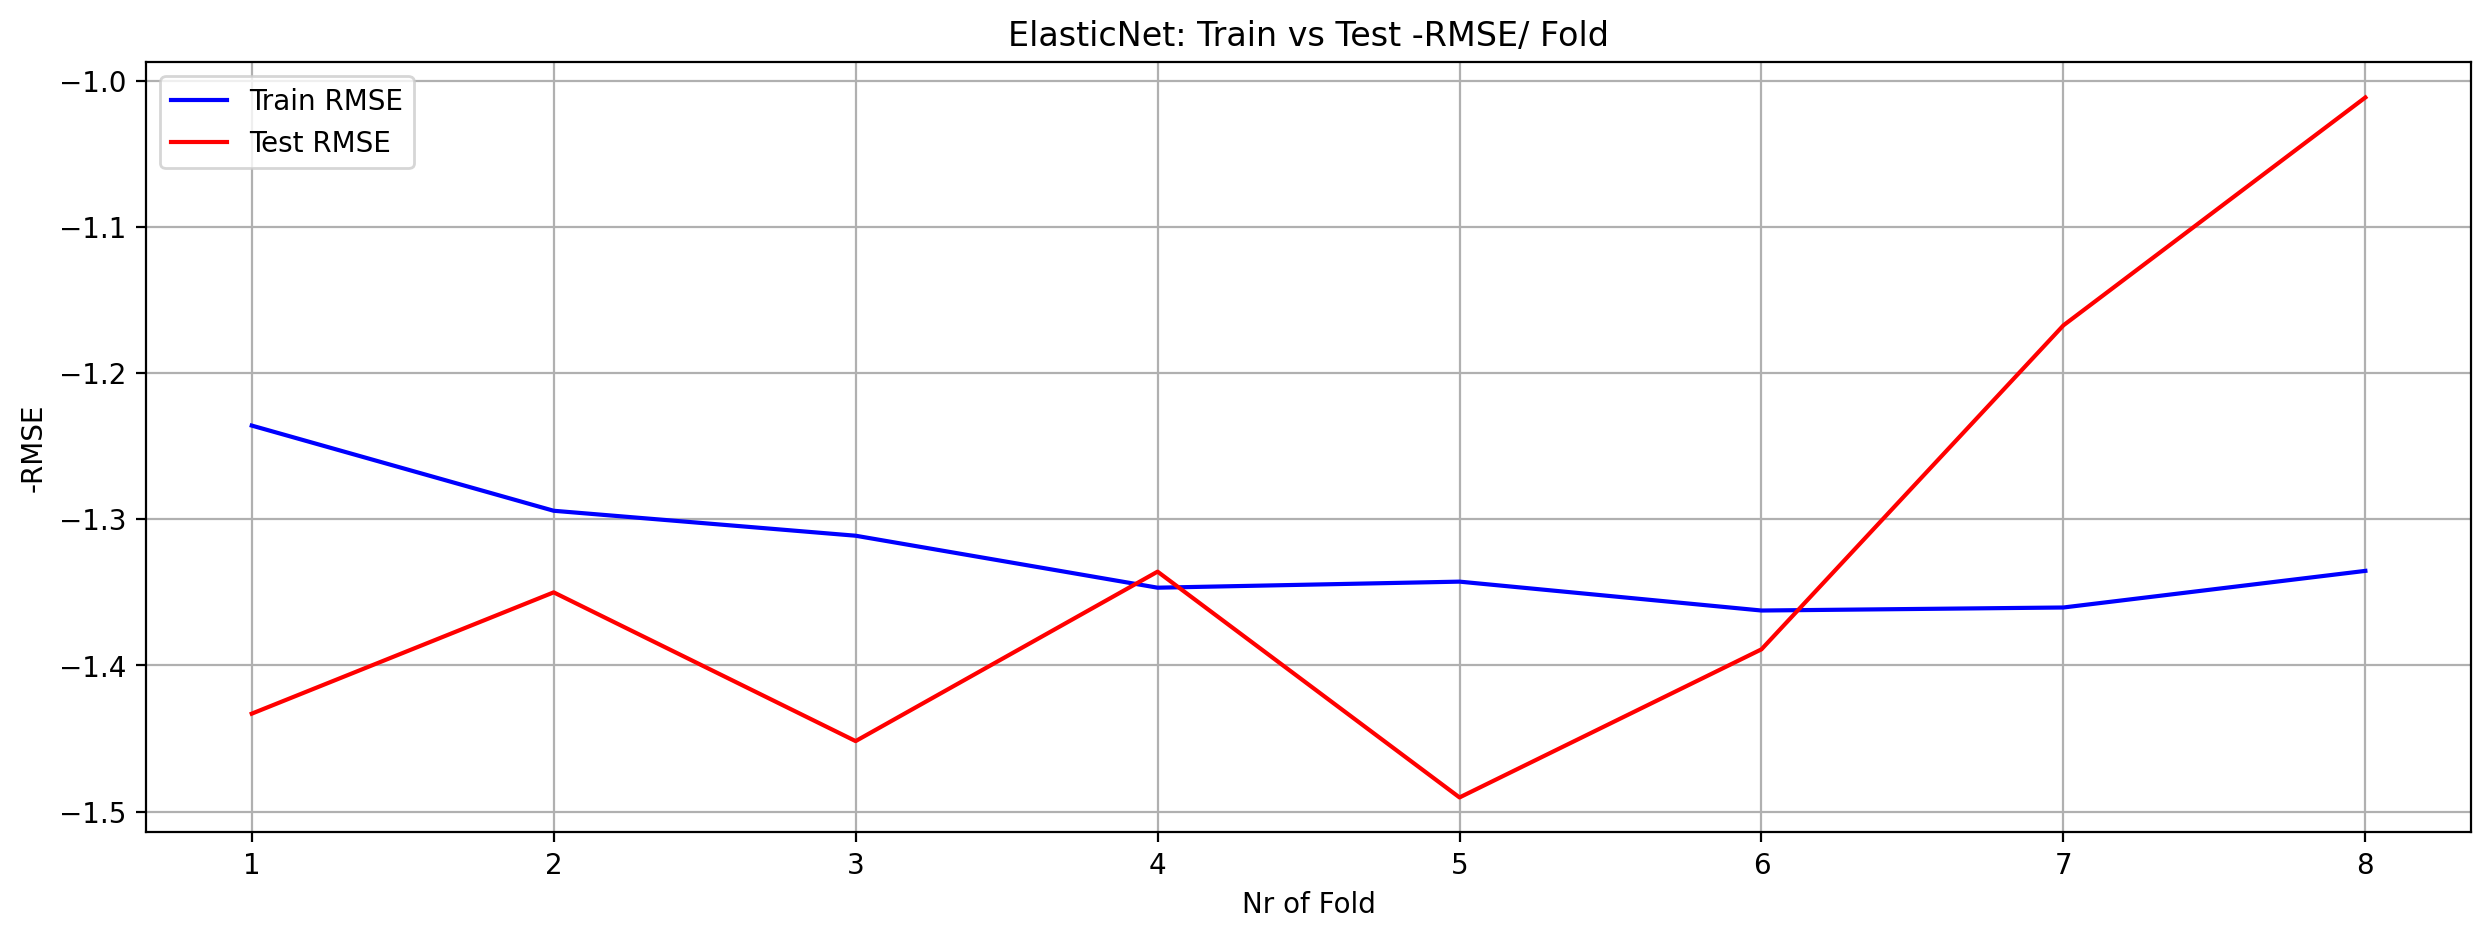

In [112]:
helper_functions.rmse_test_train_plot(elasticnet_max_params, 'ElasticNet', results_path)

In [94]:
names = ['LightGBM', 'XGBoost', 'ElasticNet']
test_values = ['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score', 'split5_test_score',
   'split6_test_score', 'split7_test_score']
train_values = ['split0_train_score',
   'split1_train_score', 'split2_train_score', 'split3_train_score',
   'split4_train_score', 'split5_train_score', 'split6_train_score',
   'split7_train_score']

results_train = [light_gbm_max_params[train_values].values[0]] + [xgb_max_params[train_values].values[0]] + [elasticnet_max_params[train_values].values[0]]
results_test = [light_gbm_max_params[test_values].values[0]] + [xgb_max_params[test_values].values[0]] + [elasticnet_max_params[test_values].values[0]]



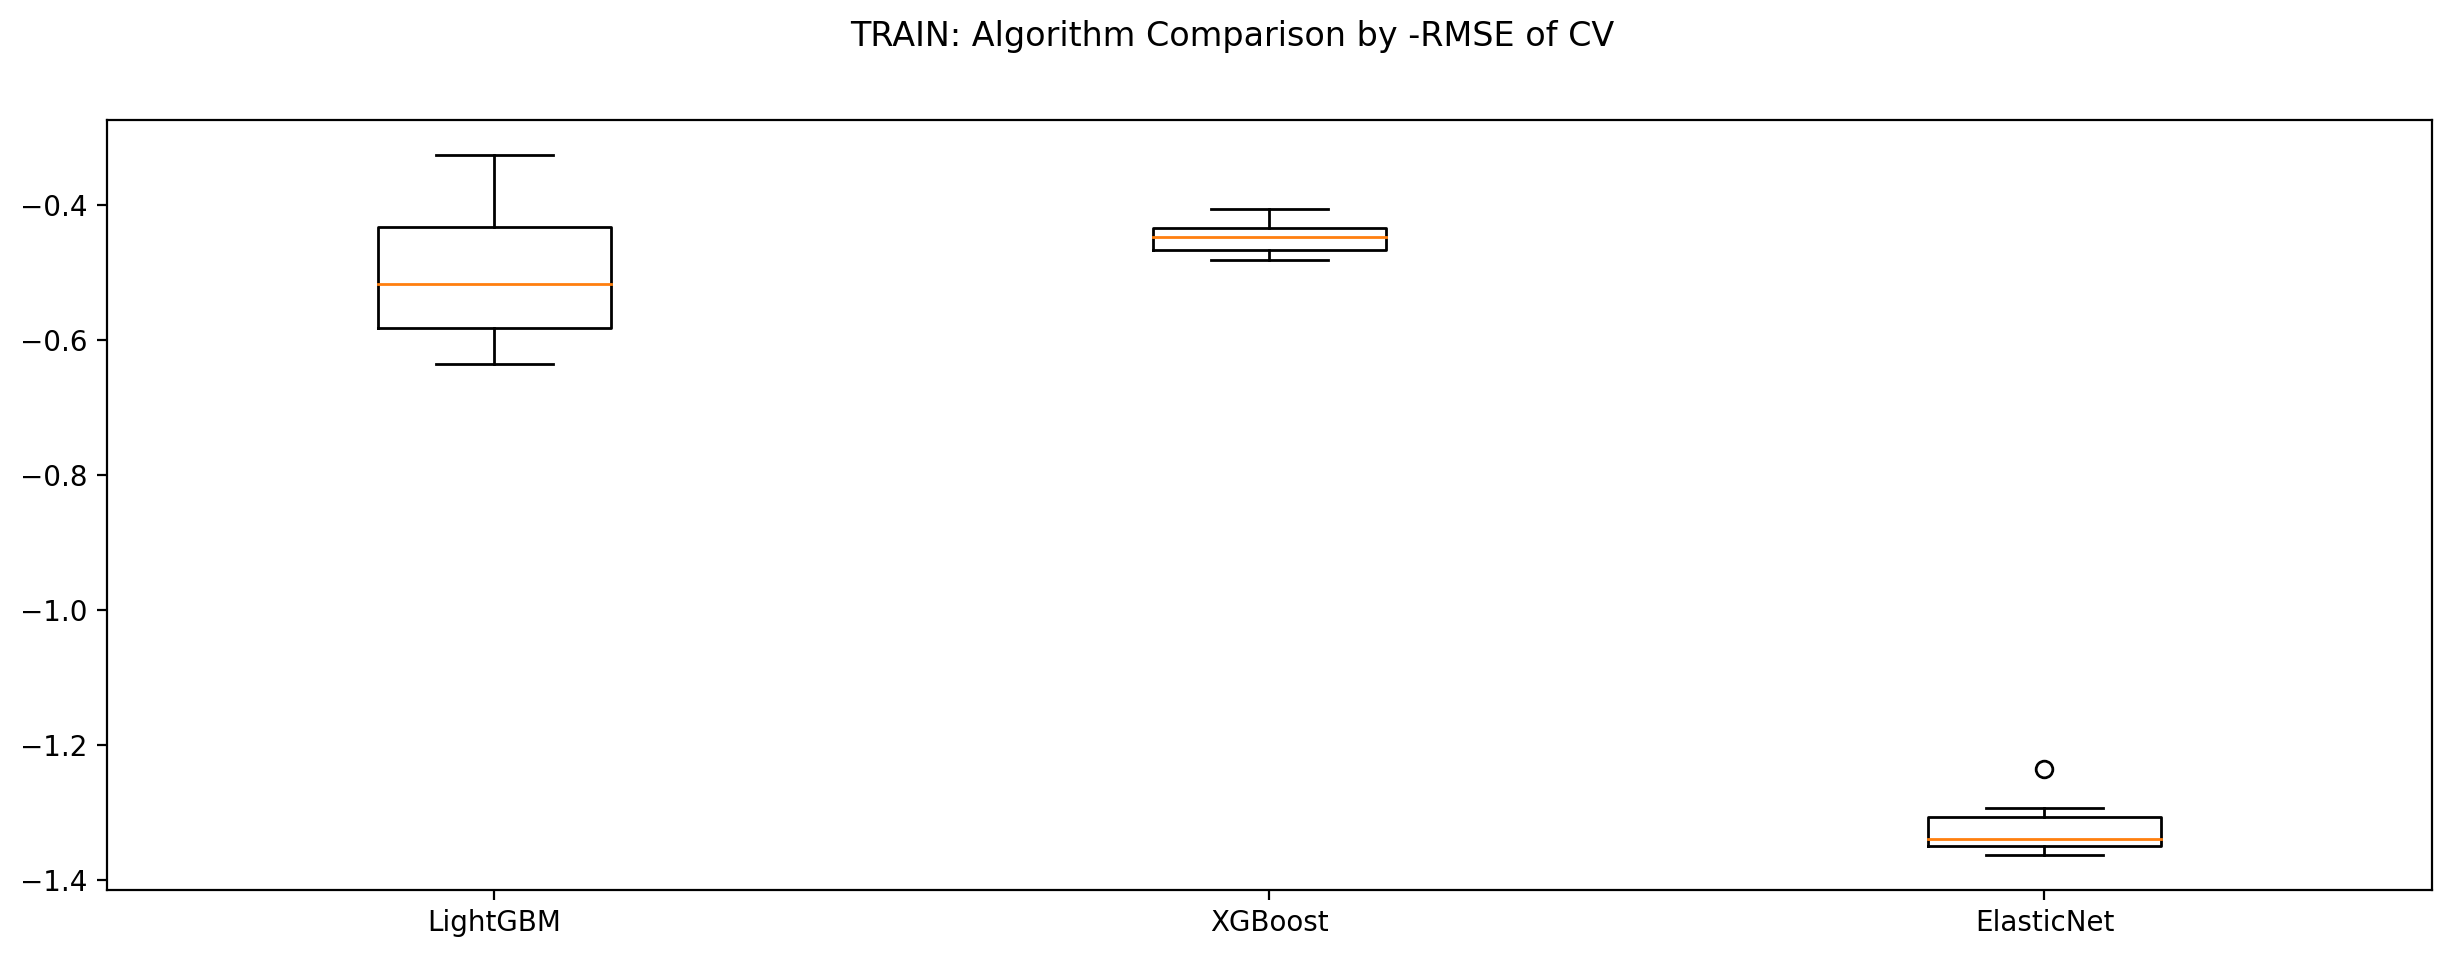

In [95]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 5))
fig.suptitle('TRAIN: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_train)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/train_boxplot.png')

plt.show()

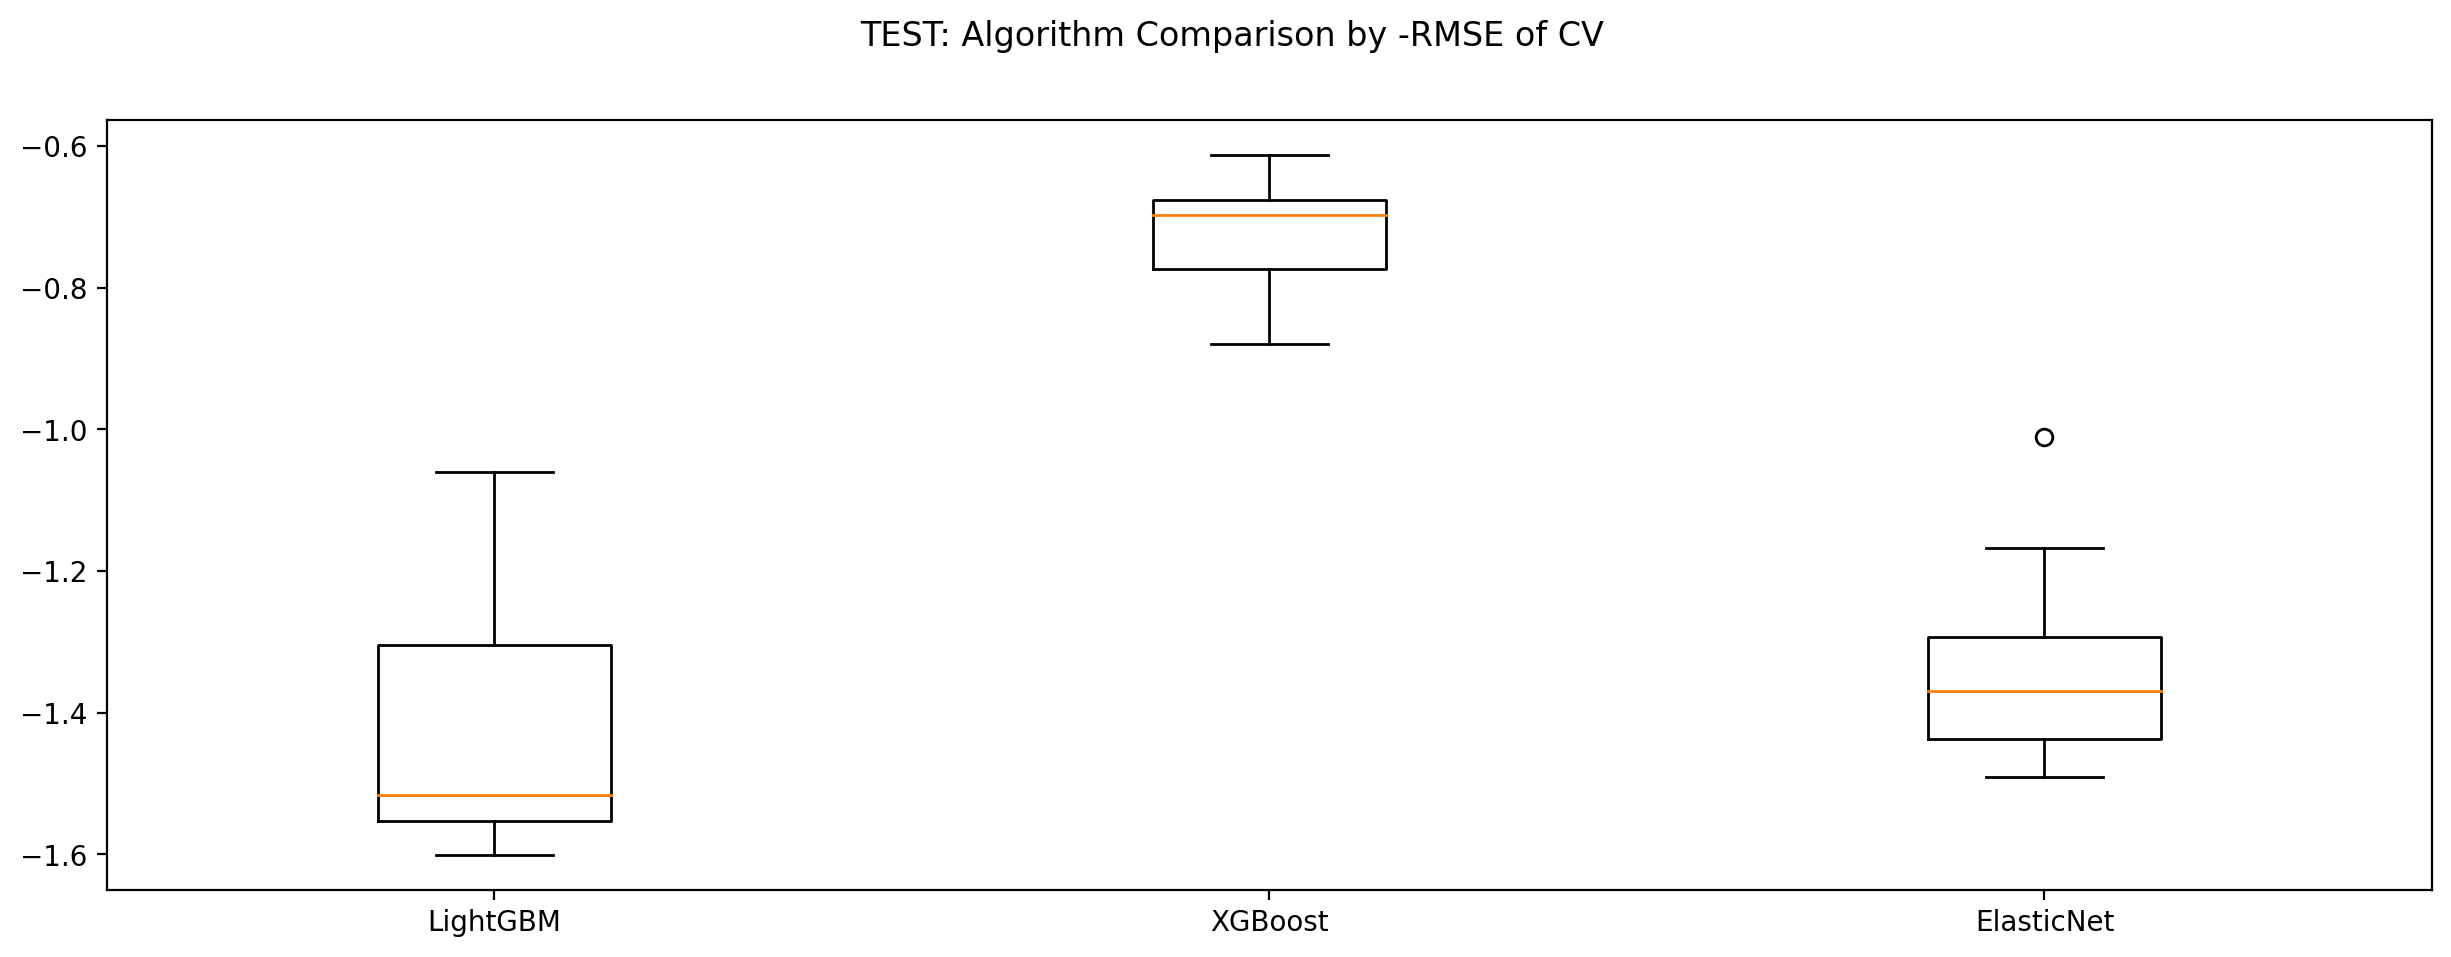

In [96]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 5))
fig.suptitle('TEST: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_test)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/test_boxplot.png')

plt.show()


## Initally big problem with overfitting: Solution Ideas

- the ratio of features used (i.e. columns used); colsample_bytree. Lower ratios avoid over-fitting.
- the ratio of the training instances used (i.e. rows used); subsample. Lower ratios avoid over-fitting.
- the maximum depth of a tree; max_depth. Lower values avoid over-fitting.
- the minimum loss reduction required to make a further split; gamma. Larger values avoid over-fitting.
- the learning rate of our GBM (i.e. how much we update our prediction with each successive tree); eta. Lower values avoid over-fitting.
- the minimum sum of instance weight needed in a leaf, in certain applications this relates directly to the minimum number of instances needed in a node; min_child_weight. Larger values avoid over-fitting.